In [2]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
    
import warnings
import keras
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from neuralnetworks.neuralnetwork import NeuralNetwork

warnings.filterwarnings("ignore") #Hide messy Numpy warnings

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 11)

# Fix random seed for reproducibility
randSeed = 42
np.random.seed(randSeed)

Populating the interactive namespace from numpy and matplotlib


Para resolver problemas com Redes Neurais, assim como qualquer problema de aprendizado de máquina, antes de elaborar uma arquitetura é necessário primeiramente entender o problema e, principalmente, compreender os dados. Esse processo é extenso e compreende muitas vezes a maior parte do trabalho, de forma que podemos pensar em uma [pirâmide]( https://hackernoon.com/the-ai-hierarchy-of-needs-18f111fcc007), em que no topo está a arquitetura da rede de fato e, antes disso, estão os processos de obtenção e manipulação de dados, ilustrado na Figura 1. Dessa forma, esse notebook tem como objetivo introduzir alguns pontos importantes da pirâmide para obtenção de melhores resultados de uma rede neural. O notebook é organizado de acordo com seis pontos principais:

* Definição do problema
* Entendendo o dataset
* Identificando problemas
* Solucionando problemas
* Correlação
* Implementando a rede neural

![alt text](../imgs/ia-hierarchy.png "Title")

# Definição do problema

Nessa atividade, será utilizado como base de dados informações dos passageiros do Titanic para identificar quais passageiros sobreviveram. No Titanic, uma das razões que causou o naufrágio  foi que não havia botes salva-vidas suficientes para os passageiros e a tripulação. Dentre os passageiros, alguns grupos de pessoas tinham maior probabilidade de sobreviver do que outros, como mulheres, crianças e a classe alta. Dessa forma, o problema consiste em utilizar rede neural para identificar quais pessoas poderiam sobreviver.

# Entendendo o dataset

Para iniciar, deve-se analisar os atributos de entrada do dataset, seus tipos e o atributo alvo (label/rótulo). Isso pode ser feito através do Pandas, biblioteca de Python específica para análise e preprocessamento de dados. Isso pode ser feito através da biblioteca Pandas, que permite analisar e preprocessar dados. 

In [3]:
# Passo 1 - Leitura do dataset 
train = pd.DataFrame(pd.read_csv("../datasets/l2q2_train.csv", index_col=[0], header=0))
test  = pd.DataFrame(pd.read_csv("../datasets/l2q2_test.csv", index_col=[0], header=0))

display(train.head())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Drop das colunas que estamos considerando pouco úteis para a resolução do problema

In [4]:
train.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
test.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

display(train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Descarta os NaNs que existirem nas colunas numericas

In [5]:
train.dropna(axis=0, how='any', inplace=True)
test.dropna(axis=0, how='any', inplace=True)

display(train.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### Passo 2 - Separar atributos e classes

In [6]:
display(train.head())
train.describe().transpose()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


,count,mean,std,min,25%,50%,75%,max
Survived,712.0,0.404494,0.491139,0.00,0.00,0.00000,1.0,1.0000
Pclass,712.0,2.240169,0.836854,1.00,1.00,2.00000,3.0,3.0000
Age,712.0,29.642093,14.492933,0.42,20.00,28.00000,38.0,80.0000
SibSp,712.0,0.514045,0.930692,0.00,0.00,0.00000,1.0,5.0000
Parch,712.0,0.432584,0.854181,0.00,0.00,0.00000,1.0,6.0000
Fare,712.0,34.567251,52.938648,0.00,8.05,15.64585,33.0,512.3292


# Identificando problemas

Mesmo com uma base de dados previamente definida, muitas vezes existem problemas que não foram tratados nela, sendo necessário analisar manualmente. Dentre os problemas, para bases de texto, três são bastante comuns:
* Instâncias com informações faltando (NaN) para determinados atributos
* Dados discrepantes e outliers
* Dados desbalanceados

Dessa forma, deve-se itentificar a presença desses problemas no dataset. 
- Dica 1: utilize funções das bibliotecas do Pandas para os dois primeiros problemas.  
- Dica 2: visualize a distribuição de instâncias por classe através de bibliotecas gráficas de Python (e.g. matplob, seaborn e pyplot).

### Distribuição

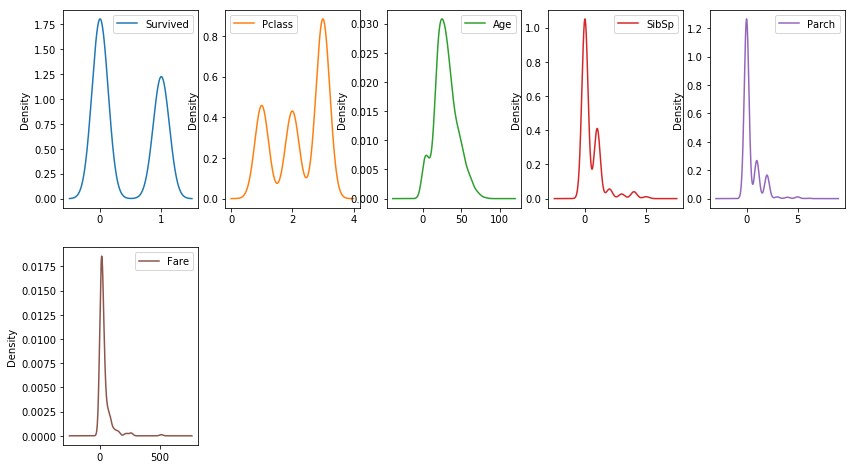

In [7]:
train.plot(kind='density', subplots=True, layout=(2,5), sharex=False, figsize = (14,8))
plt.show()

### Scatter matrix para cada par de atributos (incluindo saída)

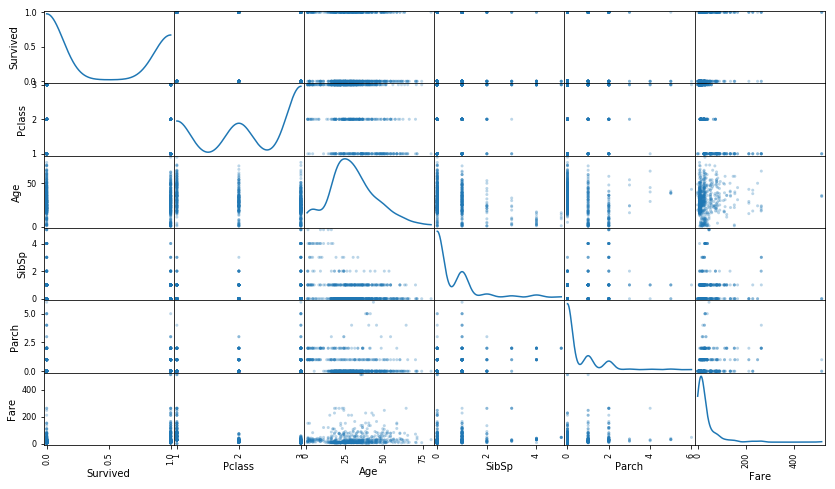

In [8]:
pd.scatter_matrix(train, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Box Plot

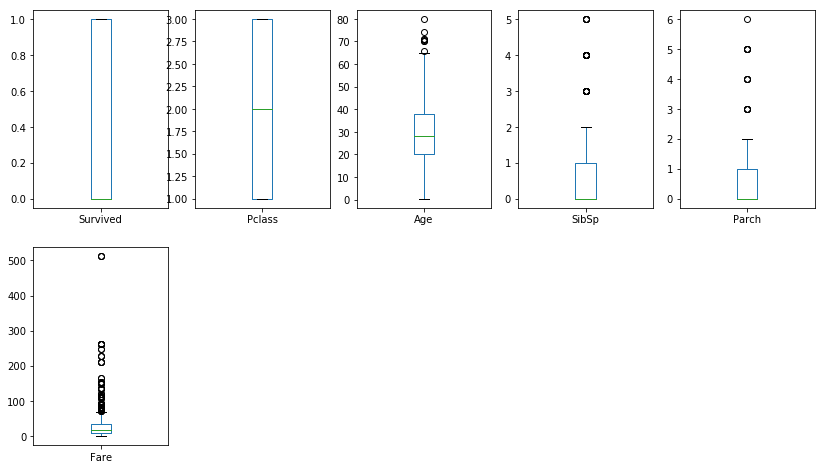

In [9]:
train.plot.box(subplots=True, layout=(2,5), sharex=False, figsize = (14,8))
plt.show()

# Solucionando Problemas

Os problemas podem ser solucionados utilizando algumas medidas estatísticas como média, mediana e moda para substituir as informações que estão faltando e dados discrepantes, ou excluir as instâncias. Além disso, quanto mais balanceado o dataset, menos propensa estará a rede a cometer erros de generalização. A resolução pode ser feita das duas formas utilizando o Pandas. 

### Agora vamos, de maneira simples, ignorar os outliers das colunas possivelmente problematicas

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


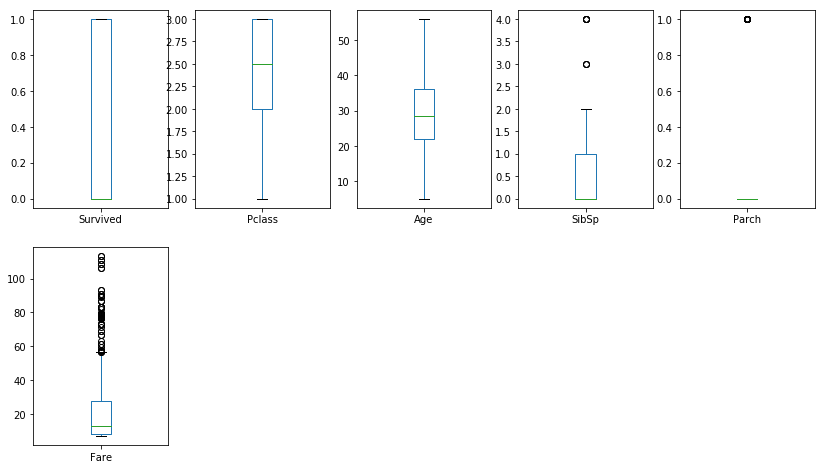

In [10]:
train = train[train["Age"] > train["Age"].quantile(0.05)]
train = train[train["Age"] < train["Age"].quantile(0.95)]

train = train[train["Fare"] > train["Fare"].quantile(0.05)]
train = train[train["Fare"] < train["Fare"].quantile(0.95)]

train = train[train["Parch"] < train["Parch"].quantile(0.95)]

display(train.head())
train.describe().transpose()

train.plot.box(subplots=True, layout=(2,5), sharex=False, figsize = (14,8))
plt.show()

# Correlação dos atributos

Uma vez que o dataset foi analisado e possíveis erros foram corrigidos, é importante também verificar a correlação dos atributos. A correlação é uma métrica estatística que mede a associação entre os atributos. Caso existam atributos altamente correlacionados, pode-se excluir alguns deles, permanecendo apenas um dos atributos correlacionados.

Dessa forma, nessa etapa, calcule a correlação entre os atributos. Considere utilizar algumas formas de visualização para melhor interpretação dos resultados.

In [11]:
train.corr(method='pearson', min_periods=1)

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.364884,0.032833,0.028743,0.088778,0.304813
Pclass,-0.364884,1.000000,-0.409239,-0.065515,-0.037851,-0.741646
Age,0.032833,-0.409239,1.000000,-0.082682,-0.068306,0.231051
SibSp,0.028743,-0.065515,-0.082682,1.000000,0.335978,0.304280
Parch,0.088778,-0.037851,-0.068306,0.335978,1.000000,0.162326
Fare,0.304813,-0.741646,0.231051,0.304280,0.162326,1.000000


# Implementando a Rede Neural

Uma vez que a base de dados foi analisada e possíveis problemas foram corrigidos, pode-se implementar a rede neural. Para esse problema, é necessário uma arquitetura multicamada MLP de no máximo 6 camadas escondidas, recomendando-se a implementação das camadas de forma gradual. Da mesma forma, cada camada deverá conter no máximo 30 neurônios. Além disso, recomenda-se a utilização de técnicas de regularização como Dropout, normalização do batch e normalização L2.

Utilize o otimizador de sua escolha para o treinamento por batch, aumente a quantidade de epochs e batch também gradativamente, não é necessário uma quantidade muito alta para resolução do problema. Ao final, mostre a curva de treinamento e a matriz de confusão obtida para o problema. 

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

# Separar atributos da saída
X_train = pd.get_dummies(train.drop(columns=["Survived"]), dummy_na=False).astype(float)
y_train = train["Survived"].astype(float).astype(float)
X_test =  pd.get_dummies(test, dummy_na=False).astype(float)
y_test =  None

display(X_train.head())

model = Sequential()
model.add(Dense(30, input_dim=10, kernel_initializer='normal', activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train.as_matrix(), y_train.as_matrix(), epochs=50, batch_size=2, verbose=True, validation_split=0.15)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
2,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
3,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
4,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
5,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0


Train on 436 samples, validate on 78 samples
Epoch 1/50
436/436 [==============================] - 0s - loss: 0.6485 - acc: 0.6307 - val_loss: 0.6118 - val_acc: 0.6282
Epoch 2/50
436/436 [==============================] - 0s - loss: 0.6222 - acc: 0.6720 - val_loss: 0.5714 - val_acc: 0.7179
Epoch 3/50
436/436 [==============================] - 0s - loss: 0.6078 - acc: 0.6651 - val_loss: 0.5438 - val_acc: 0.7436
Epoch 4/50
436/436 [==============================] - 0s - loss: 0.5858 - acc: 0.6995 - val_loss: 0.5194 - val_acc: 0.7564
Epoch 5/50
436/436 [==============================] - 0s - loss: 0.5748 - acc: 0.6950 - val_loss: 0.4984 - val_acc: 0.7692
Epoch 6/50
436/436 [==============================] - 0s - loss: 0.5568 - acc: 0.7110 - val_loss: 0.4792 - val_acc: 0.7821
Epoch 7/50
436/436 [==============================] - 0s - loss: 0.5380 - acc: 0.7179 - val_loss: 0.4554 - val_acc: 0.7821
Epoch 8/50
436/436 [==============================] - 0s - loss: 0.5340 - acc: 0.7294 - val_lo

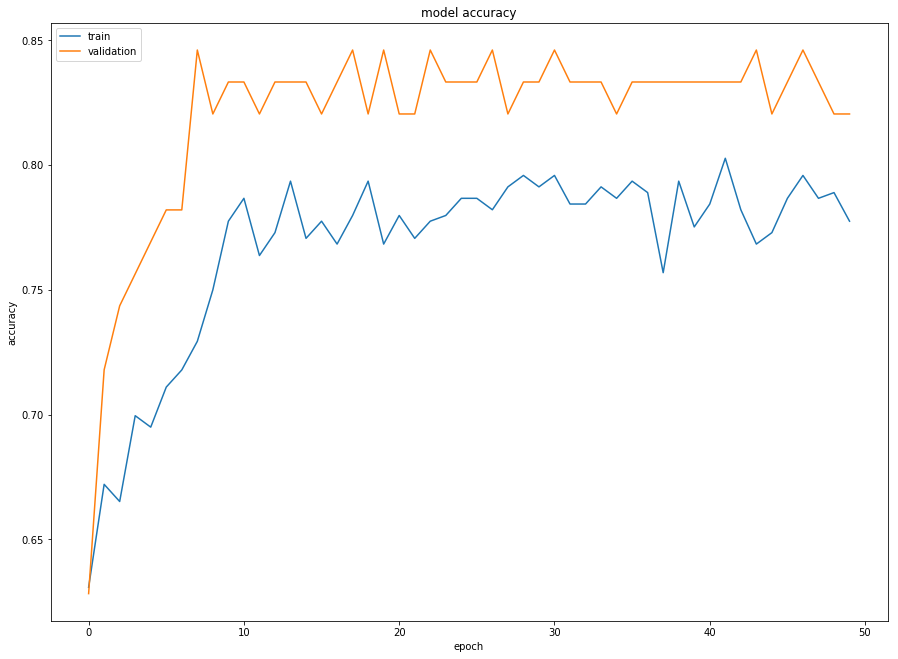

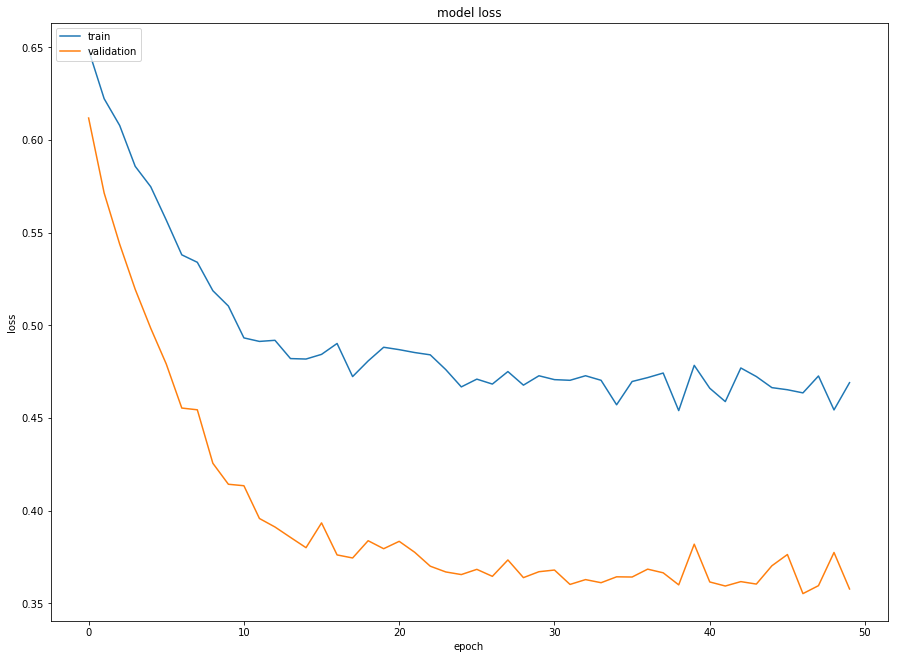

In [41]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
confusion_matrix(y_train.as_matrix(), np.round(model.predict(X_train.as_matrix())))

array([[270,  49],
       [ 60, 135]])